In [1]:
import gc
import os
import joblib
import numpy as np
import pandas as pd
import random as rn
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras
from itertools import product
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.client import device_lib

In [2]:
np.random.seed(35)
rn.seed(35)
tf.random.set_seed(35)
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6944313234909651949
xla_global_id: -1
]


In [3]:
file_path = "../../data/BG Ex data/"
model_path = "../../model/"
stack_model_path = "../../LBStack model/"
file_list = os.listdir(file_path)

In [4]:
fold_info = np.load("../../data/BG_Fold_Info.npz", allow_pickle=True)

FOLD = 4

test = fold_info["test"][FOLD]

In [5]:
test_file = test[0]

In [6]:
test_data = np.load(file_path+test_file+".npz")
test_12x = np.concatenate(test_data["gen12"]).reshape(-1, 12, 1)
test_24x = np.concatenate(test_data["gen24"]).reshape(-1, 24, 1)
test_36x = np.concatenate(test_data["gen36"]).reshape(-1, 36, 1)
test_x = {
    "test_12x":test_12x,
    "test_24x":test_24x,
    "test_36x":test_36x
}
test_y =test_data["y12"].reshape(-1, 1)

In [7]:
model_path = model_path + f'Fold{FOLD}/'
model_list = os.listdir(model_path)

In [8]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [9]:
pred_list = []

for model in model_list:
    params = model.split("_")
    
    MODEL_NAME = params[0]
    SEQ = params[1]
    HIDDEN = params[2]
    BATCH = params[3][:-3]    
    
    MODEL = keras.models.load_model(
        model_path + model,
        custom_objects={"root_mean_squared_error": root_mean_squared_error}
    )
    
    if SEQ=="12":
        pred = MODEL.predict(test_x["test_12x"]).tolist()
        pred_list.append(pred)
    elif SEQ=="24":
        pred = MODEL.predict(test_x["test_24x"]).tolist()
        pred_list.append(pred)
    else:
        pred = MODEL.predict(test_x["test_36x"]).tolist()
        pred_list.append(pred)
        
pred_result = np.mean(pred_list, axis=0)

In [10]:
pred_v_list = []
for v_list in pred_list:
    pred_v = [v[0] for v in v_list]
    pred_v_list.append(pred_v)
    
pred_v_df = pd.DataFrame(np.array(pred_v_list).T)

In [11]:
linear_model_path = stack_model_path + f'Fold{FOLD}/LR.pkl'
lasso_model_path = stack_model_path + f'Fold{FOLD}/LASSO.pkl'

In [12]:
LR_MODEL = joblib.load(linear_model_path)
LASSO_MODEL = joblib.load(lasso_model_path)

In [13]:
soft = pred_result.flatten().astype(int).astype(float)
linear = LR_MODEL.predict(pred_v_df).astype(int).astype(float)
lasso = LASSO_MODEL.predict(pred_v_df).astype(int).astype(float)
real = test_y.flatten().astype(float)
naive = np.roll(real, 6)

soft = soft[6:400]
linear = linear[6:400]
lasso = lasso[6:400]
real = real[6:400]
naive = naive[6:400]

C:\Users\user\anaconda3\envs\GluStack\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\user\anaconda3\envs\GluStack\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


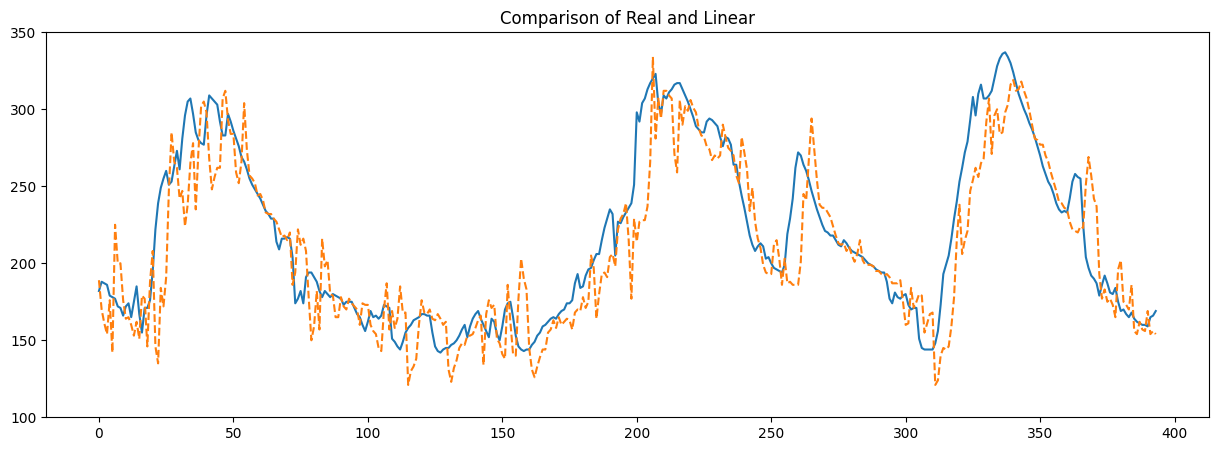

In [38]:
# x 축은 배열의 인덱스로 설정
x = np.arange(len(soft))

# 그래프 그리기
plt.figure(figsize=(15, 5))
plt.plot(x, real, label='Real')
plt.plot(x, linear, label='Linear', linestyle='--')
plt.title('Comparison of Real and Linear')

# y 축 범위 설정
plt.ylim(100, 350)

# 그래프 저장
plt.savefig('../../Linear.png')

# 그래프 표시
plt.show()

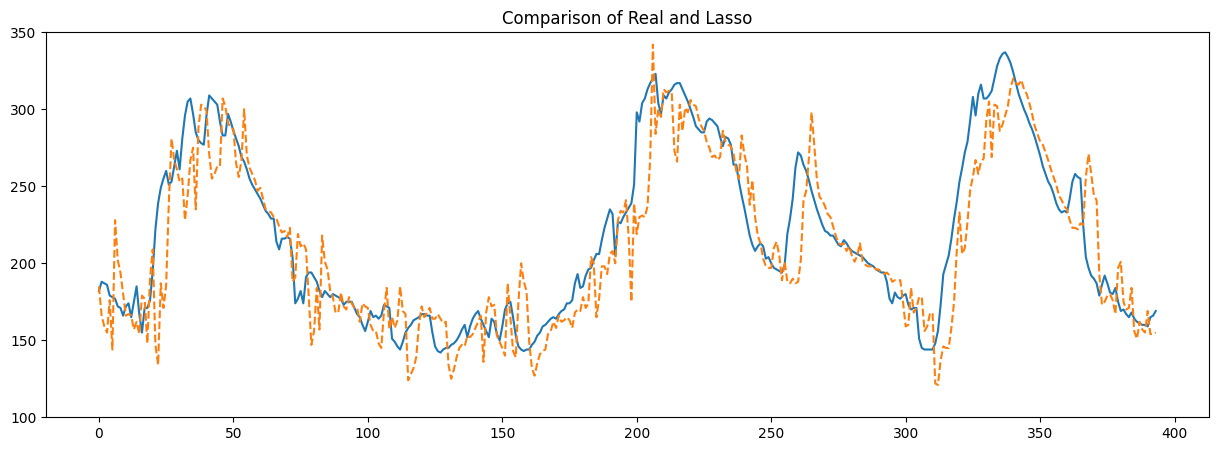

In [39]:
# x 축은 배열의 인덱스로 설정
x = np.arange(len(soft))

# 그래프 그리기
plt.figure(figsize=(15, 5))
plt.plot(x, real, label='Real')
plt.plot(x, lasso, label='Lasso', linestyle='--')
plt.title('Comparison of Real and Lasso')

# y 축 범위 설정
plt.ylim(100, 350)

# 그래프 저장
plt.savefig('../../Lasso.png')

# 그래프 표시
plt.show()

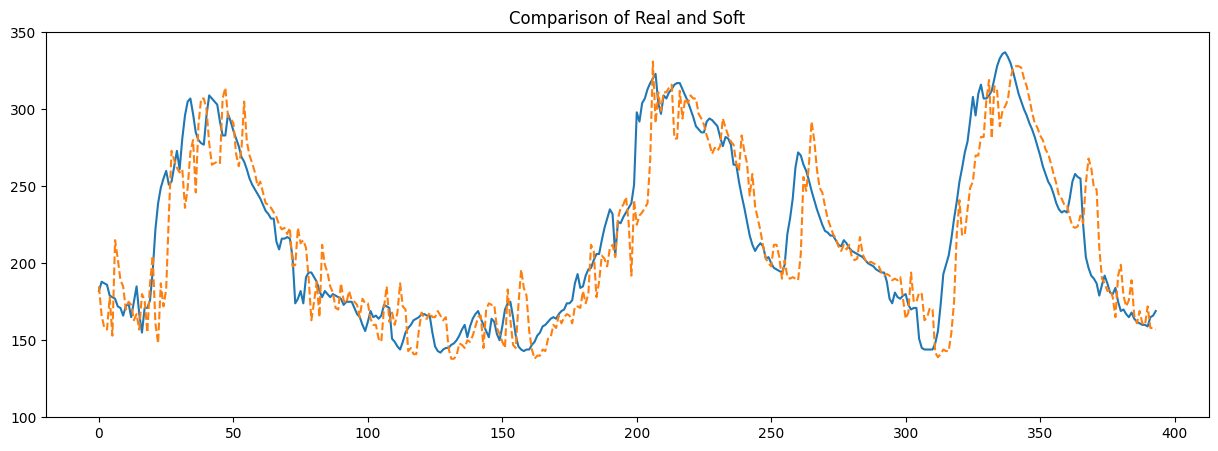

In [40]:
# x 축은 배열의 인덱스로 설정
x = np.arange(len(soft))

# 그래프 그리기
plt.figure(figsize=(15, 5))
plt.plot(x, real, label='Real')
plt.plot(x, soft, label='Soft', linestyle='--')
plt.title('Comparison of Real and Soft')

# y 축 범위 설정
plt.ylim(100, 350)

# 그래프 저장
plt.savefig('../../Soft.png')

# 그래프 표시
plt.show()

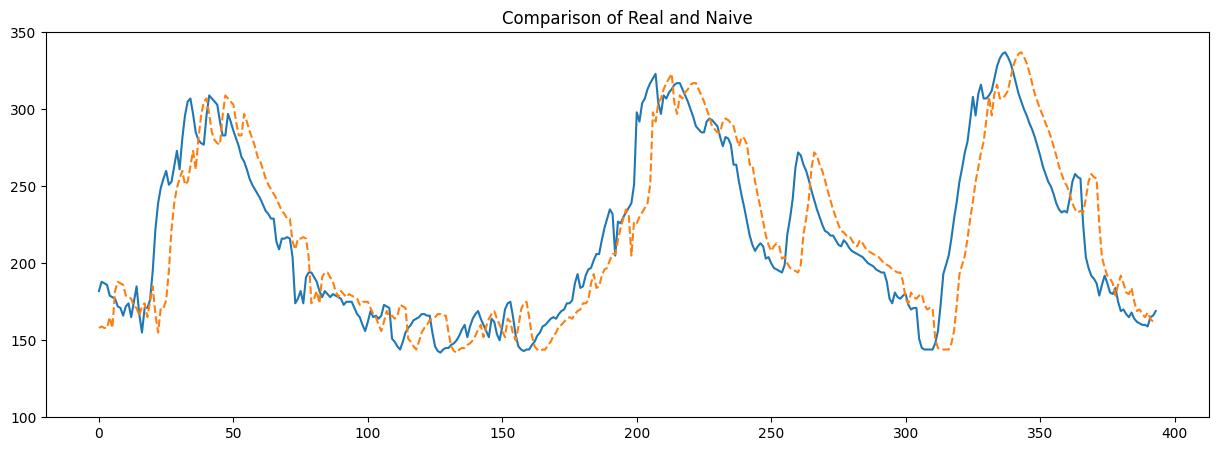

In [41]:
# x 축은 배열의 인덱스로 설정
x = np.arange(len(soft))

# 그래프 그리기
plt.figure(figsize=(15, 5))
plt.plot(x, real, label='Real')
plt.plot(x, naive, label='Naive', linestyle='--')
plt.title('Comparison of Real and Naive')

# y 축 범위 설정
plt.ylim(100, 350)

# 그래프 저장
plt.savefig('../../Naive.png')

# 그래프 표시
plt.show()